In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('test2_modified_2.csv')

## Modeling
1. features / label
2. train, test split
3. boosting algorithm
 - 랜덤 포레스트에 비해 성능이 좋은 알고리즘 사용
 - 단, 데이터에 대한 이해 없이 무조건적으로 좋은 성능을 기대하면 x
4. 성능 점수가 낮을 것으로 판단
 - 알고리즘의 문제가 아니라 현재 데이터는 무언가 부족한 상황
 - 하이퍼 파라미터 튜닝에만 의존할 것이 아니라 feature/label에 데이터의 특성이 잘 반영되어 있는지 확인 필요

In [3]:
features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30',
            'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']
label = 'RUL'

In [4]:
train, test = df[0::2], df[1::2] # 홀짝으로 분할
train, test = train.reset_index(), test.reset_index()
X_train, y_train = train[features], train[label]
X_test, y_test = test[features], test[label]

### 모델 기획 및 수립
- Tree 기반 알고리즘
 - XGboost, CatBoost, LightGBM
- GBDT 계열 알고리즘

#### 알고리즘 이해를 도와주는 배경지식
- Decision Tree
- Random Fores(Bagging)
- GBDT(Boosting)

### XGBoost
- eXtreme Gradient Boosting
- 내부적으로 병렬 연산이 가능하도록 부스팅 구조를 개선하여 속도 향상
 - 부스팅 방식의 고질적인 문제점: 속도가 느린 직렬 연산(이전 모델이 수행된 결과를 이용)
- LightGBM, CatBoost 대비 많은 reference
- 일반인 그룹이 개발
- 과적합 방지를 위한 Regularizer 동작

#### Regularizer
- 일반화 달성 및 과적합 방지를 위한 penalty 항, 제약사항
- L1, L2 규제
 - Lasso Regression: 선형회귀에 L1을 반영
 - Ridge Regression: 선형회귀에 L2를 반영
 - ElasticNet: L1 + L2
- L1은 특정 feature를 사용하지 않는 것으로 feature selection과 유사하게 동작
- L2는 feature 사용 비중을 분산시켜 다양한 feature를 사용하는 것
- 수식에 절댓값이 있으면 L1, 제곱이 있으면 L2

### LightGBM
- XGBoost의 경량화 버전으로, XGBoost에 비해 속도 향상
- Microsoft 개발
 - 특정 단체/기업에 의해 개발되어 라이센스에 자유롭지 못하고 적은 reference

### CatBoost
- Categorical Boosting
- 러시아의 그룹사 Yandex 개발
- 디폴트 값 설정이 잘 되어있는 편이지만 속도가 느린 편
- 경우의 수 처리에 특화된 XGBoost의 개선판

In [5]:
# !pip install xgboost, catboost, lightgbm

# Anaconda Prompt 관리자 권한 실행 후 설치 진행

In [6]:
from xgboost import XGBRegressor as xg
from catboost import CatBoostRegressor as cb
from lightgbm import LGBMRegressor as lg
from sklearn.ensemble import RandomForestRegressor as rf

In [8]:
# 비교 수행을 위한 네 가지 모델 생성
# catboost는 모델 생성 시 출력되는 내용이 많아 이를 보지 않기 위해 silent=True 적용
m1, m2, m3, m4 = rf(n_jobs=-1), xg(n_jobs=-1), lg(n_jobs=-1), cb(silent=True)

# 모델 학습
m1.fit(X_train, y_train)
m2.fit(X_train, y_train)
m3.fit(X_train, y_train)
m4.fit(X_train, y_train)

## Evaluation
- 학습 데이터와 테스트 데이터에 대한 예측 성능 평가

In [9]:
print('RandomForest:', m1.score(X_train, y_train), m1.score(X_test, y_test))
print('XGBoost:', m2.score(X_train, y_train), m2.score(X_test, y_test))
print('LightGBM:', m3.score(X_train, y_train), m3.score(X_test, y_test))
print('CatBoost:', m4.score(X_train, y_train), m4.score(X_test, y_test))

# 전체적으로 학습 데이터에 대한 예측 성능은 좋지만,
# 테스트 데이터에 대한 예측 성능이 많이 떨어지는 모습 
# 학습 데이터와 테스트 데이터의 예측 성능 차이가 매우 큰 상황

# 우수한 성능을 자랑하는 알고리즘들의 예측 확률이 60% 수준
# 예측 성능이 좋지 않을 때 하이퍼파라미터 튜닝을 고집할 것이 아니라,
# 가지고 있는 데이터가 분석을 진행하기에 부족한 것은 아닌지 확인 필요

# 하이퍼파라미터 튜닝은 어느정도 성능이 나왔고 시간적 여유가 있을 때 성능을 더 높이기 위해 사용
# 반면, 지금 이 정도의 성능이라면 데이터 자체에 문제가 있다고 판단(학습을 위한 준비가 부족한 데이터)
# 분석 방향성에 맞게 데이터가 잘 준비되었는지 data preparation 과정을 다시 한 번 점검

RandomForest: 0.9485058103777914 0.627812482070384
XGBoost: 0.8906117568834724 0.590061925041379
LightGBM: 0.7678763179899359 0.6274747881162159
CatBoost: 0.8085709829084649 0.6280756366998017


#### 점수 향상을 위한 고려사항
- 다양한 센서 수치가 RUL 값에 따라 커지거나 작아지는 상황
- 시각화 과정에서 그래프가 직선 형태가 아닌 곡선 형태인 것을 확인
- 잔존 유효 수명이 많이 남았을 때와 그렇지 않을 때의 기울기 차이 존재
- 어느 시점에 갑자기 증가/감소하는 기울기에 대한 정보 추가 필요

#### 잔존 유효 수명(RUL)이 0에 가까울수록 그래프의 기울기가 크다는 내용을 반영
- +/- 10의 오차를 가정
 - RUL 예측값이 300인 경우: 290~310회 사용 가능
 - RUL 예측값이 7인 경우: 이미 고장났거나 17회 사용 가능
- 예측값이 작은 경우 조금이라도 예측에 오차가 생기면 문제 발생
 - 동일하게 10만큼의 오차가 존재하더라도 숫자가 작을 때(고장에 근접)가 더 시급한 상황
 - 따라서 숫자가 크거나 작을 때 정도의 차이를 다르게 적용하는 방식 필요
- 현재 RUL 컬럼은 행 번호가 하나씩 증가할 때마다 값이 동일하게 1씩 감소
 - 실제로는 RUL이 작아질수록 의미가 커지므로 이를 반영하는 것이 중요

#### 로그 변환 / 루트 적용
- 0에 가까워질수록 의미가 커질 때 로그 또는 루트 사용
 - 로그 함수의 0에 가까울수록 기울기가 커지는 성질 활용
 - np.sqrt() 함수 사용

In [11]:
# a=100, b=101
point_a = 100
point_b = point_a + 1

print(point_b - point_a)
print(np.log(point_b) - np.log(point_a))

# b - a = 1
# 로그의 차이는 1보다 작음: 0.009

1
0.009950330853167877


In [12]:
# a=2, b=3
point_a = 2
point_b = point_a + 1

print(point_b - point_a)
print(np.log(point_b) - np.log(point_a))

# a가 2인 경우에는 로그 변환 후 차이가 a가 100인 경우에 비해 큼
# 즉, 로그 변환하면 작은 숫자끼리의 1 차이가 큰 숫자끼리의 1 차이보다 큼

# 따라서 숫자가 작아질 때 가중치 부여 가능
# np.sqrt() 적용 시에도 마찬가지

1
0.4054651081081645


#### 로그 변환
- RUL 컬럼을 로그 변환한 RUL_log 컬럼 생성

In [13]:
df['RUL_log'] = df['RUL'].apply(lambda x: np.log(x))
df

# RUL 값이 작은 경우에 RUL이 1 차이날 때 RUL_log 값들의 차이가 더 큰 것을 확인 가능
# 간격이 동일하게 1씩 적용되는 RUL 컬럼과 달리 그래프의 곡선 형태를 반영

,unit,cycle,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL,RUL_log
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192,5.257495
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,191,5.252273
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,190,5.247024
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,189,5.241747
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,188,5.236442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,643.49,1597.98,1428.63,551.43,2388.19,9065.52,48.07,519.49,2388.26,8137.60,8.4956,397,38.49,22.9735,5,1.609438
20627,100,197,643.54,1604.50,1433.58,550.86,2388.23,9065.11,48.04,519.68,2388.22,8136.50,8.5139,395,38.30,23.1594,4,1.386294
20628,100,198,643.42,1602.46,1428.18,550.94,2388.24,9065.90,48.09,520.01,2388.24,8141.05,8.5646,398,38.44,22.9333,3,1.098612
20629,100,199,643.23,1605.26,1426.53,550.68,2388.25,9073.72,48.39,519.67,2388.23,8139.29,8.5389,395,38.29,23.0640,2,0.693147


In [14]:
# 체크 포인트: RUL_log 컬럼이 추가된 데이터
df.to_csv('test2_modified_3.csv', index=False)

### 모델 생성 및 평가

In [15]:
df = pd.read_csv('test2_modified_3.csv')
df.head()

,unit,cycle,T24,T30,T50,P30,Nf,Nc,Ps30,phi,NRf,NRc,BPR,htBleed,W31,W32,RUL,RUL_log
0,1,1,641.82,1589.70,1400.60,554.36,2388.06,9046.19,47.47,521.66,2388.02,8138.62,8.4195,392,39.06,23.4190,192,5.257495
1,1,2,642.15,1591.82,1403.14,553.75,2388.04,9044.07,47.49,522.28,2388.07,8131.49,8.4318,392,39.00,23.4236,191,5.252273
2,1,3,642.35,1587.99,1404.20,554.26,2388.08,9052.94,47.27,522.42,2388.03,8133.23,8.4178,390,38.95,23.3442,190,5.247024
3,1,4,642.35,1582.79,1401.87,554.45,2388.11,9049.48,47.13,522.86,2388.08,8133.83,8.3682,392,38.88,23.3739,189,5.241747
4,1,5,642.37,1582.85,1406.22,554.00,2388.06,9055.15,47.28,522.19,2388.04,8133.80,8.4294,393,38.90,23.4044,188,5.236442


In [16]:
features = ['T24', 'T30', 'T50', 'P30', 'Nf', 'Nc', 'Ps30',
            'phi', 'NRf', 'NRc', 'BPR', 'htBleed', 'W31', 'W32']
label = 'RUL_log'

train, test = df[0::2], df[1::2] # 홀짝으로 분할
train, test = train.reset_index(), test.reset_index()
X_train, y_train = train[features], train[label]
X_test, y_test = test[features], test[label]

In [17]:
# 모델 생성
m1, m2, m3, m4 = rf(n_jobs=-1), xg(n_jobs=-1), lg(n_jobs=-1), cb(silent=True)

# 모델 학습
m1.fit(X_train, y_train)
m2.fit(X_train, y_train)
m3.fit(X_train, y_train)
m4.fit(X_train, y_train)

In [18]:
print('RandomForest:', m1.score(X_train, y_train), m1.score(X_test, y_test))
print('XGBoost:', m2.score(X_train, y_train), m2.score(X_test, y_test))
print('LightGBM:', m3.score(X_train, y_train), m3.score(X_test, y_test))
print('CatBoost:', m4.score(X_train, y_train), m4.score(X_test, y_test))

# 로그 변환 이후 학습 성능은 비슷하지만 테스트 성능이 확실히 높아진 것을 확인 가능
# 이처럼 데이터의 특성을 파악하고 원하는 방향에 맞게 데이터를 가공하는 역량 필요

# XGBoost의 성능이 가장 낮은 것은 하이퍼파라미터 튜닝을 수행하지 않았기 때문
# 현재 배깅 방식인 랜덤 포레스트 모델의 성능이 높지만,
# 하이퍼파라미터 튜닝을 진행하면 부스팅 계열인 XGBoost의 성능이 더 우수할 가능성 존재

# 시간적인 여유가 된다면 하이퍼파라미터 튜닝을 수행하지만 드라마틱한 변화를 가져다주지 x
# 일반적으로 모델들의 성능이 비슷하다면 랜덤 포레스트 모델의 결과를 제출

RandomForest: 0.9794928456654146 0.8497084786469272
XGBoost: 0.9505269071781702 0.8352280840970485
LightGBM: 0.9059628093954009 0.8535134200337308
CatBoost: 0.9189883199585236 0.85485146832631


### Hyperparameter Tuning
- GridSearch, RandomSearch, Optimizer 세 가지 방식 존재

In [19]:
# XGBoost
# docstring 보고 실수형의 하이퍼파라미터를 하나 골라 임의의 실수를 넣어서 테스트
sample_model = xg(n_jobs=-1, reg_alpha=0.9)
sample_model.fit(X_train, y_train)
tr_score = sample_model.score(X_train, y_train)
te_score = sample_model.score(X_test, y_test)
print(tr_score, te_score)

# 전달되는 값에 따라서 성능이 조금씩 달라지므로,
# 여러 개의 하이퍼파라미터 중 어떤 것을 넣어야 성능이 가장 좋을지 생각하는 것이 중요

0.9514148053384803 0.8374766433896377


#### Optimizer(최적화)
- 특정한 지점을 찾는 과정
- 정의역을 하이퍼파라미터로, 치역을 평가지표로 하는 함수를 구성하여 표현

In [20]:
# reg_alpha를 정의역으로 하는 함수 구현
# 입력한 alpha 값을 hyperparameter로 할 때 테스트 데이터에 대한 예측 점수를 반환

def alpha_search(alpha):
    sample_model = xg(n_jobs=-1, reg_alpha=alpha)
    sample_model.fit(X_train, y_train)
    return sample_model.score(X_test, y_test)

In [21]:
alpha_search(0.1)

0.8343780207250381

#### XGBoost

In [22]:
# XGBoost 모델에 4개의 hyperparameter를 적용한 점수를 반환하는 함수 구현

def hyper_param_1(alpha, lambda_, rate, depth):
    sample_model = xg(n_jobs=-1,
                      reg_alpha=alpha, reg_lambda=lambda_, learning_rate=rate, max_depth=int(depth))
                      # max_depth는 정수 형태로 인자를 받는 하이퍼 파라미터
    sample_model.fit(X_train, y_train)
    return sample_model.score(X_test, y_test)

In [23]:
hyper_param_1(0.1, 0.3, 0.6, 10)

0.7828271261779888

In [24]:
hyper_param_1(0.2, 0.7, 0.1, 15)

# 수동으로 값을 무작위 변경해가며 최적화하는 것은 불가능하므로,
# 최적화를 수행하는 bayesian optimization 모듈 사용

0.838853038940656

In [25]:
from bayes_opt import BayesianOptimization as bo

# 0과 아주 근사한 작은 값부터 1과 아주 근사한 값까지 범위를 설정
epsilon = 0.1 ** 10
float_range = (epsilon, 1-epsilon) # 범위는 튜플 형태로 설정

# reg_alpha, reg_lambda, learning_rate: 실수형 인자 / max_depth: 정수형 인자
pbounds = {'alpha':float_range, 'lambda_':float_range, 'rate':float_range, 'depth':(5, 30)}

# Bayesian Optimization: f에 최적화 함수, pbounds에 hyperparameter의 범위 입력
optimizer = bo(f=hyper_param_1, pbounds=pbounds)

In [26]:
# maximize(): target 값이 가장 높은 조합을 찾는 method
# acq: 최적화 방식을 설정 -> poi 방식 적용(default: ucb)
optimizer.maximize(acq='poi', n_iter=20)

# 앞에서 도출된 가장 높은 target 점수에 비해 점수가 높은 경우 보라색으로 표시

# 최적화 결과를 바탕으로 pbounds를 조정하며 최적화 반복 수행
# ex) depth 값이 20 이상일 때 대체로 점수가 높았다면 depth 범위를 20 이상으로 조정

|   iter    |  target   |   alpha   |   depth   |  lambda_  |   rate    |
-------------------------------------------------------------------------
|  1        |  0.8111   |  0.196    |  26.24    |  0.6001   |  0.3433   |
|  2        |  0.7682   |  0.862    |  25.35    |  0.4602   |  0.742    |
|  3        |  0.7635   |  0.07972  |  12.39    |  0.1393   |  0.7017   |
|  4        |  0.8175   |  0.9874   |  17.93    |  0.5665   |  0.3535   |
|  5        |  0.7733   |  0.1514   |  21.46    |  0.6659   |  0.5979   |
|  6        |  0.718    |  0.08576  |  19.59    |  0.6647   |  0.8543   |
|  7        |  0.8061   |  0.9431   |  17.56    |  0.2323   |  0.4706   |
|  8        |  0.8184   |  0.9884   |  17.93    |  0.5658   |  0.3531   |
|  9        |  0.8172   |  0.9922   |  17.92    |  0.5627   |  0.3515   |
|  10       |  0.7773   |  0.4528   |  29.59    |  0.0578   |  0.6204   |
|  11       |  0.8065   |  0.9723   |  17.51    |  0.1201   |  0.4671   |
|  12       |  0.8362   |  0.8018   | 

In [27]:
optimizer.max  # 최댓값 확인

{'target': 0.8462942017350575,
 'params': {'alpha': 0.11902059796253166,
  'depth': 6.639324513778334,
  'lambda_': 0.14423512722591836,
  'rate': 0.18578927305008527}}

In [28]:
##### 주의 #####

# 여러 개의 hyperparameter 적용하는 경우,
# hyperparameter 간 상호작용이 이루어지므로 모든 파라미터를 동시에 적용한 상태로 최적화
# 개별적으로 첫 번째 최적값 찾고, 그 다음 최적값 찾아서 합치는 것 x

In [29]:
param_set = optimizer.max['params']
param_set

{'alpha': 0.11902059796253166,
 'depth': 6.639324513778334,
 'lambda_': 0.14423512722591836,
 'rate': 0.18578927305008527}

In [30]:
# best XGBoost model

tuned_model = xg(n_jobs=-1,
                 reg_alpha=param_set['alpha'],
                 reg_lambda=param_set['lambda_'],
                 learning_rate=param_set['rate'],
                 max_depth=int(param_set['depth']))

tuned_model.fit(X_train, y_train)
tuned_model.score(X_test, y_test)

0.8462942017350575

In [31]:
print('XGBoost-tuned:', tuned_model.score(X_train, y_train), tuned_model.score(X_test, y_test))

XGBoost-tuned: 0.9374844997541272 0.8462942017350575


#### LightGBM
- XGBoost 모델에 비해 최적화 속도 향상

In [32]:
# LightGBM 모델에 4개의 hyperparameter를 적용한 점수를 반환하는 함수 구현

def hyper_param_2(leaves, depth, alpha, lambda_):
    sample_model = lg(n_jobs=-1,
                      num_leaves=int(leaves), max_depth=int(depth), reg_alpha=alpha, reg_lambda=lambda_)
                      # num_leaves, max_depth는 정수 형태로 인자를 받는 하이퍼 파라미터
    sample_model.fit(X_train, y_train)
    return sample_model.score(X_test, y_test)

In [34]:
epsilon = 0.1 ** 10
float_range = (epsilon, 1-epsilon)

# reg_alpha, reg_lambda: 실수형 인자 / num_leaves, max_depth: 정수형 인자
pbounds = {'alpha':float_range, 'lambda_':float_range, 'leaves':(5, 30), 'depth':(5, 30)}

optimizer = bo(f=hyper_param_2, pbounds=pbounds)
optimizer.maximize(acq='poi', n_iter=20)

|   iter    |  target   |   alpha   |   depth   |  lambda_  |  leaves   |
-------------------------------------------------------------------------
|  1        |  0.8542   |  0.5241   |  19.55    |  0.439    |  20.68    |
|  2        |  0.8543   |  0.8301   |  26.56    |  0.8057   |  16.79    |
|  3        |  0.8544   |  0.709    |  24.86    |  0.5069   |  12.07    |
|  4        |  0.8539   |  0.9044   |  22.85    |  0.6567   |  26.76    |
|  5        |  0.8552   |  0.04063  |  18.5     |  0.136    |  13.69    |
|  6        |  0.8539   |  0.9509   |  25.75    |  0.4213   |  28.39    |
|  7        |  0.8552   |  0.03651  |  18.48    |  0.1336   |  13.66    |
|  8        |  0.8543   |  0.1781   |  18.97    |  0.3309   |  13.67    |
|  9        |  0.8539   |  0.08729  |  26.69    |  0.8769   |  25.02    |
|  10       |  0.8544   |  0.1076   |  18.34    |  0.3591   |  13.9     |
|  11       |  0.8545   |  0.02202  |  18.38    |  0.2555   |  13.52    |
|  12       |  0.8544   |  0.3408   | 

In [41]:
optimizer.max

{'target': 0.8552425886554341,
 'params': {'alpha': 0.04063279201727325,
  'depth': 18.50255256241283,
  'lambda_': 0.13600783396778426,
  'leaves': 13.686433304219287}}

In [42]:
param_set = optimizer.max['params']
param_set

{'alpha': 0.04063279201727325,
 'depth': 18.50255256241283,
 'lambda_': 0.13600783396778426,
 'leaves': 13.686433304219287}

In [45]:
# best LightGBM model

tuned_model = lg(n_jobs=-1,
                 reg_alpha=param_set['alpha'],
                 reg_lambda=param_set['lambda_'],
                 num_leaves=int(param_set['leaves']),
                 max_depth=int(param_set['depth']))

tuned_model.fit(X_train, y_train)
tuned_model.score(X_test, y_test)

0.8552425886554341

In [47]:
print('LightGBM-tuned:', tuned_model.score(X_train, y_train), tuned_model.score(X_test, y_test))

LightGBM-tuned: 0.8827519135675541 0.8552425886554341


#### CatBoost(생략)
- docstring에 디폴트 값이 제공되지 않으므로(none) 공식문서 확인 필요
- https://catboost.ai/en/docs/concepts/parameter-tuning
 - 하이퍼파라미터로 어떤 값을 주어야 할지 참고
 - 자료형에 대한 설명이 없으면 대부분 실수형 인자

## XAI(eXplainable AI)
- SHAP
- PDP

#### SHAP

In [48]:
# XGBoost-tuned 모델 활용

param_set = {'alpha': 0.11902059796253166,
             'depth': 6.639324513778334,
             'lambda_': 0.14423512722591836,
             'rate': 0.18578927305008527}

model = xg(n_jobs=-1,
           reg_alpha=param_set['alpha'],
           reg_lambda=param_set['lambda_'],
           learning_rate=param_set['rate'],
           max_depth=int(param_set['depth']))

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.18578927305008527, max_bin=256,
             max_cat_to_onehot=4, max_delta_step=0, max_depth=6, max_leaves=0,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=-1, num_parallel_tree=1, predictor='auto',
             random_state=0, reg_alpha=0.11902059796253166,
             reg_lambda=0.14423512722591836, ...)

In [49]:
import warnings
warnings.simplefilter(action='ignore')

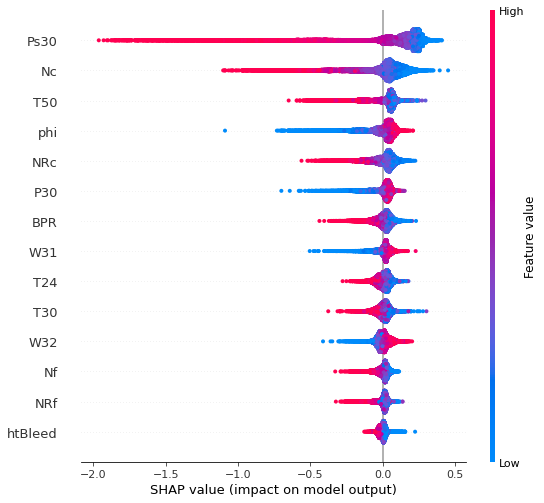

In [50]:
import shap

shap.initjs()
X = df[features]
shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X)

##### 해석용 문장 #####

# 컬럼의 의미를 모르는 상태로 분석을 진행한 센서 데이터에 대한 최종 해석
# -------------------------------------------------------------------------
# Ps30, Nc, T50, NRc, BPR, T24, T30은 값이 클수록 label에 - 방향으로 기여
# phi, P30, W31, W32는 작을수록 label에 - 방향으로 기여
# 그 외 변수는 중요도에서 확인했듯이 shapley value 자체가 크지 않아 해석에서 제외

#### PDP(부분의존도)

In [51]:
from sklearn.inspection import plot_partial_dependence as pdp

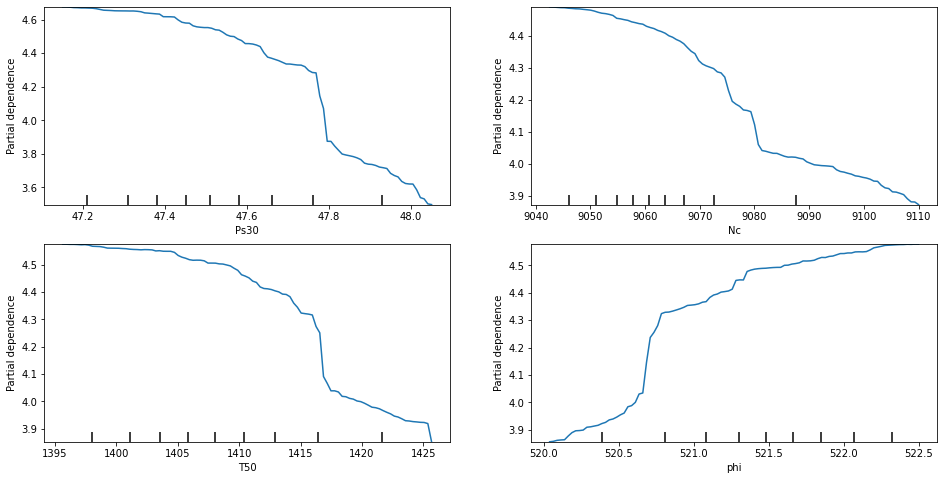

In [52]:
# one-way plot

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(16, 8)

model = rf(n_estimators = int(121.30078559138837),
           max_depth = int(13.390414831657525),
           max_features = 0.34971236824977475,
           min_samples_split=1.0000000000000006e-10,
           min_samples_leaf=1.0000000000000006e-10 / 2)

model.fit(X_train, y_train)

pdp(model, X, ['Ps30'], ax=ax1)
pdp(model, X, ['Nc'], ax=ax2)
pdp(model, X, ['T50'], ax=ax3)
pdp(model, X, ['phi'], ax=ax4)

# 조금씩 감소하다가 어느 순간 크게 감소하는 구간 존재(phi는 크게 증가하는 구간)
# 기울기가 변화하는 특정 구간에서 고장의 위험이 있다고 해석 가능

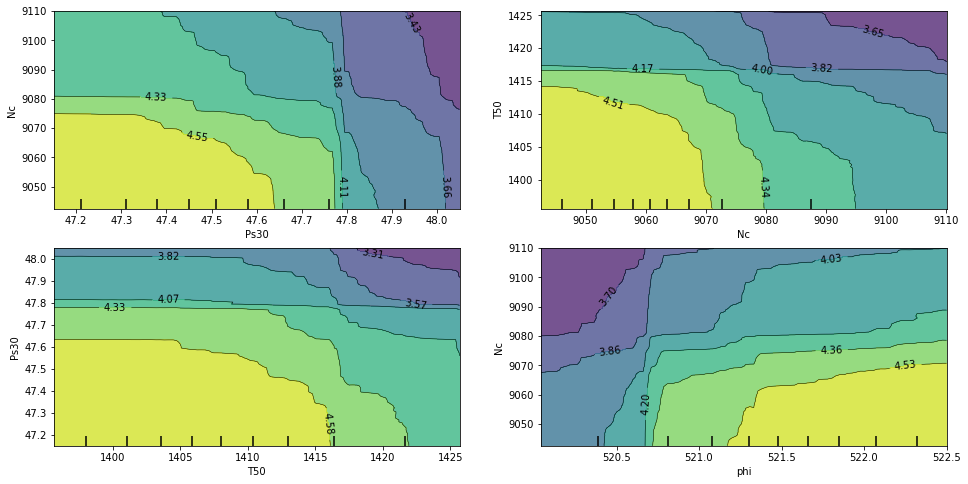

In [53]:
# two-way plot

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(ncols=2, nrows=2)
fig.set_size_inches(16, 8)

pdp(model, X, [('Ps30', 'Nc')], ax=ax1)
pdp(model, X, [('Nc', 'T50')], ax=ax2)
pdp(model, X, [('T50', 'Ps30')], ax=ax3)
pdp(model, X, [('phi', 'Nc')], ax=ax4)

# ax1 -> 밝을수록 수명이 많이 남고, 어두울수록 수명이 적게 남은 것
# Ps30 47.4, Nc 9060 정도면 수명이 많이 남고, Ps30 48.0, Nc 9100 정도면 고장이 가까워 교체가 시급